In [ ]:
using Turing
using StatsPlots
using Optim

In [ ]:
PRINT_PROGRESS = true
include("read_data.jl")
include("utils.jl")
include("lecture/plot_utils.jl");

### Dataset: World-Wide Monthly Air Passengers

In [ ]:
base_plot(air_passengers_2013_2018)

In [ ]:
# upwards_trend_data = air_passengers_2013_2018[2009 .<= air_passengers_2013_2018[!,"Year"],:]
# base_plot(upwards_trend_data)

# x = upwards_trend_data[!,"Date"]
# y = upwards_trend_data[!,"Total"];

x = air_passengers_2013_2018[!,"Date"]
y = air_passengers_2013_2018[!,"Total"];

In [ ]:
@model function trend_model(x::Vector{Float64}, y)
    slope ~ Normal(0,1)
    intercept ~ Normal(6,1)
    error ~ InverseGamma(2,3)
    
    # UPGRADE: sample the number of changepoints and multiple changepoint candidates
    n_changepoints ~ DiscreteUniform(1,5)
    changepoints ~ filldist(Uniform(0, x[end] - x[1]), 5)
    adjustments ~ filldist(Normal(0,1), 5)
    
    k = slope
    m = intercept
    j = 1
    
    # for prior/posterior predictive check
    if ismissing(y)
        y = zeros(length(x))
    end
    
    for i in eachindex(y)
        t = x[i] - x[1]
        k = slope
        m = intercept
        # UPGRADE: now iterate over dynamic number of changepoints
        for j in 1:n_changepoints
            changepoint = changepoints[j]
            adjustment = adjustments[j]
            if changepoint ≤ t
                k += adjustment
                m -= changepoint * adjustment
            end
        end
        
        y[i] ~ Normal(k * t + m, error+1e-5)
    end
end

In [ ]:
Turing.Random.seed!(0)
res = sample(trend_model(x, y), NUTS(), 3000, progress=PRINT_PROGRESS)
res

In [ ]:
Turing.Random.seed!(0)
res = sample(trend_model(x,y), MH(), 3000, progress=PRINT_PROGRESS);

In [ ]:
_, map_vector = get_map(res)
plot_trend_model_3_1(air_passengers_2013_2018, map_vector)

## Debugging

In [ ]:
plot(res[["slope", "intercept", "n_changepoints", "changepoints[1]", "adjustments[1]"]])

### Prior Predictive Check

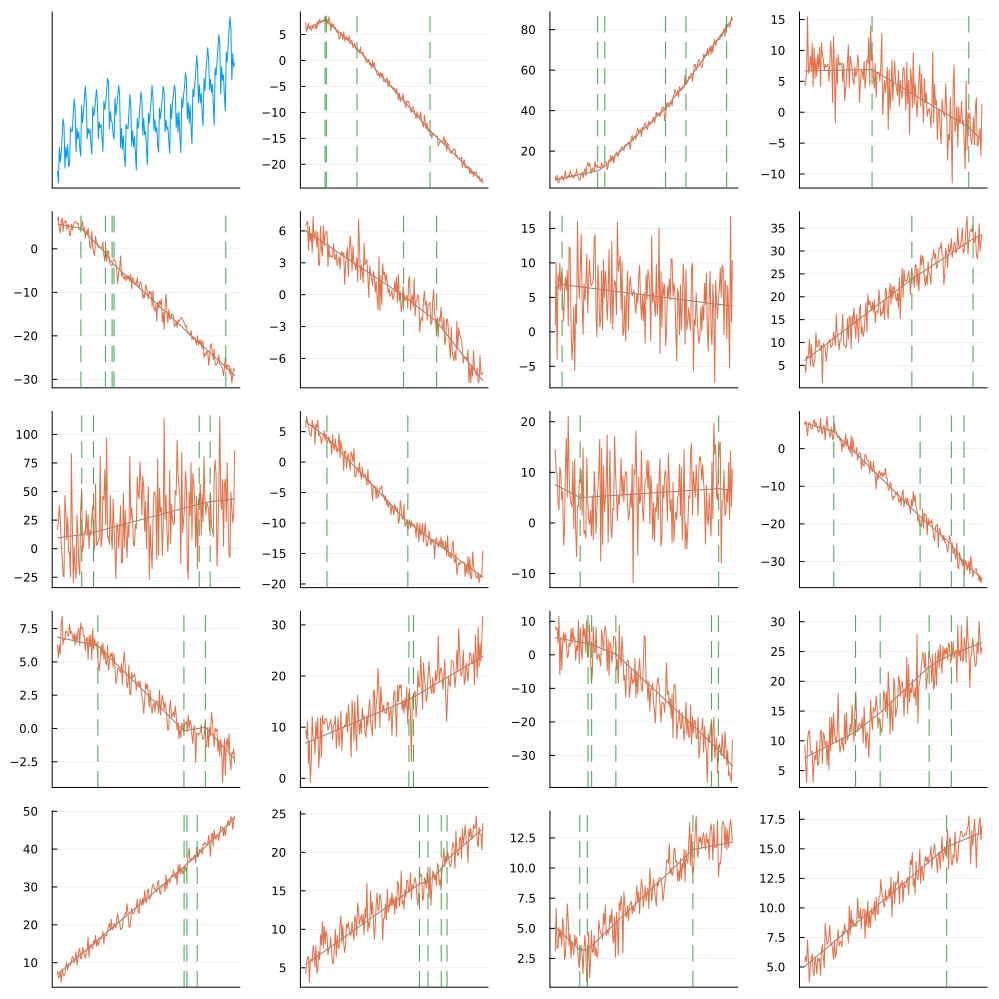

In [11]:
Turing.Random.seed!(0)
x = air_passengers_2013_2018[!,"Date"]

# use probalistic program as a generative model
res_prior = sample(trend_model(x, missing), Prior(), 19, progress=false)

t_min = x[1]
t_max = x[end]

p = plot(x, air_passengers_2013_2018[!,"Total"], legend=false, xticks=[], yticks=[])
ps = [p]
for i in 1:length(res_prior)
    _, trace = get_trace(res_prior,i)
    slope, intercept = trace[1:2]
    n_changepoints = Int(trace[4])
    changepoints = trace[5:9][1:n_changepoints]
    adjustments = trace[10:14][1:n_changepoints]
    y_from_prior = trace[15:end]
    p = plot(x, t -> trend_model_3_1_f(t - t_min, slope, intercept, changepoints, adjustments), color=:gray, legend=false, xticks=[])#, yticks=[])
    plot!(p, x, y_from_prior)
    
    cps = changepoints .+ t_min
    vline!(p, cps[(t_min .< cps) .& (cps .< t_max)], linestyle=:dash)
    push!(ps, p)
end
plot(ps..., layout=(5,4), size=(1000,1000))

### Fake Data Simulation

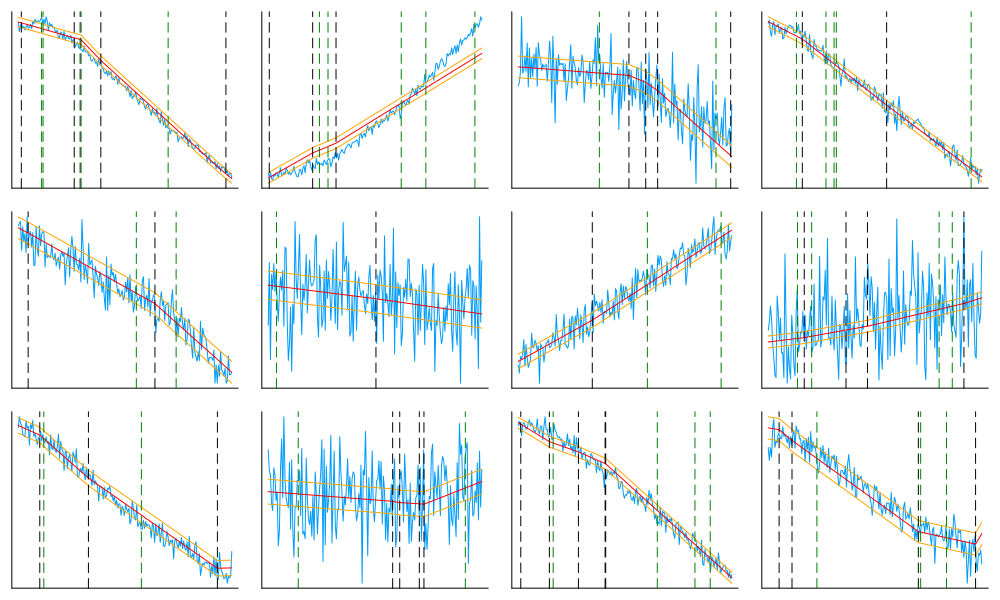

In [12]:
ps = []
for i in 1:12
    # for each of the simulated data sets ...
    _, trace = get_trace(res_prior,i)
    # slope, intercept = trace[1:2]
    n_changepoints = Int(trace[4])
    true_changepoints = trace[5:9][1:n_changepoints]
    # adjustments = trace[10:14][1:n_changepoints]
    y_from_prior = trace[15:end]

    # ... perform posterior inference ...
    Turing.Random.seed!(10)
    ppc_res = sample(trend_model(x, y_from_prior), MH(), 3000, progress=false)

    # ... and check if we can recover the true latents    
    names, map_vector = get_map(ppc_res)
    # println(names[5:9])
    # println(names[10:14])

    p = plot_trend_model_3_1((x, y_from_prior), map_vector)
    vline!(true_changepoints .+ t_min, linestyle=:dash, color=:green)
    plot!(p, xticks=[], yticks=[], xlabel="", ylabel="")
    
    push!(ps,p)
end
plot(ps..., layout=(3,4), size=(1000,600))